In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Important ideas that allows to generate images:

**Idea 1**. We can generate a random image, and using network layers, we can learn to do it properly

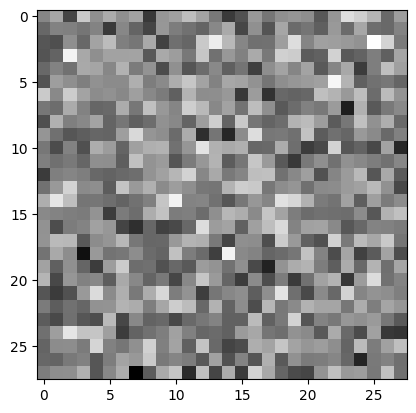

In [2]:
with torch.no_grad():
    x = torch.randn(100)
    x = nn.Linear(100, 28*28)(x)
    x = x.view(28, 28)
    plt.imshow(x, cmap='gray')

We can use more complex network structures, using CNNs, which we know include local information. For this we will use a ConvTranspose2d layer, which is the 'inverse' of the Conv2d layer.

ConvTranspose2d algorithm:
- The kernel is moved over the input tensor. 
- At each position, element-wise product is performed between kernel and corresponding region
- Results are summed up to produce the output

In [3]:
with torch.no_grad():
    conv = nn.ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=1, padding=0, bias=False)
    conv.weight.fill_(1.0)
    x = torch.ones(4*4).view(1, 1, 4, 4)*1.0
    print(conv(x))

tensor([[[[1., 2., 3., 3., 2., 1.],
          [2., 4., 6., 6., 4., 2.],
          [3., 6., 9., 9., 6., 3.],
          [3., 6., 9., 9., 6., 3.],
          [2., 4., 6., 6., 4., 2.],
          [1., 2., 3., 3., 2., 1.]]]])


In [4]:
# stride
with torch.no_grad():
    conv = nn.ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=2, padding=0, bias=False)
    conv.weight.fill_(1.0)
    x = torch.ones(4*4).view(1, 1, 4, 4)*1.0
    print(conv(x))

tensor([[[[1., 1., 2., 1., 2., 1., 2., 1., 1.],
          [1., 1., 2., 1., 2., 1., 2., 1., 1.],
          [2., 2., 4., 2., 4., 2., 4., 2., 2.],
          [1., 1., 2., 1., 2., 1., 2., 1., 1.],
          [2., 2., 4., 2., 4., 2., 4., 2., 2.],
          [1., 1., 2., 1., 2., 1., 2., 1., 1.],
          [2., 2., 4., 2., 4., 2., 4., 2., 2.],
          [1., 1., 2., 1., 2., 1., 2., 1., 1.],
          [1., 1., 2., 1., 2., 1., 2., 1., 1.]]]])


In [5]:
# padding
with torch.no_grad():
    conv = nn.ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=1, padding=1, bias=False)
    conv.weight.fill_(1.0)
    x = torch.ones(4*4).view(1, 1, 4, 4)*1.0
    print(conv(x))

tensor([[[[4., 6., 6., 4.],
          [6., 9., 9., 6.],
          [6., 9., 9., 6.],
          [4., 6., 6., 4.]]]])


In [6]:
# even-sized kernel
with torch.no_grad():
    conv = nn.ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=1, padding=0, bias=False)
    conv.weight.fill_(1.0)
    x = torch.ones(4*4).view(1, 1, 4, 4)*1.0
    print(conv(x))

tensor([[[[1., 2., 2., 2., 1.],
          [2., 4., 4., 4., 2.],
          [2., 4., 4., 4., 2.],
          [2., 4., 4., 4., 2.],
          [1., 2., 2., 2., 1.]]]])


In [7]:
# even-sized kernel, stride
with torch.no_grad():
    conv = nn.ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=2, padding=0, bias=False)
    conv.weight.fill_(1.0)
    x = torch.ones(4*4).view(1, 1, 4, 4)*1.0
    print(conv(x))

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.]]]])


Generate images using ConvTranspose2d

torch.Size([1, 1, 28, 28])


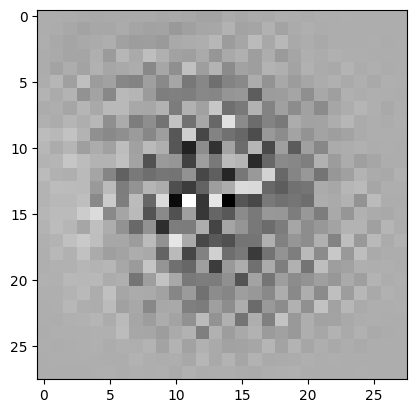

In [8]:
with torch.no_grad():
    x = torch.randn(1, 1, 10*10)
    x = x.view(1, 1, 10, 10)
    x = nn.ConvTranspose2d(1, 5, kernel_size=7, stride=1, output_padding=0, bias=False)(x)
    x = nn.ReLU()(x)
    x = nn.ConvTranspose2d(5, 10, kernel_size=7, stride=1, output_padding=0, bias=False)(x)
    x = nn.ReLU()(x)
    x = nn.ConvTranspose2d(10, 1, kernel_size=7, stride=1, output_padding=0, bias=False)(x)
    print(x.shape)
    plt.imshow(x.squeeze(), cmap='gray')

How to train this generative network?:
- Using direct backpropagation do not work, because the random nature of the input makes imposible to learn the transformations from real images. 
- In this way, we could not define a proper a loss.

**Idea 2**. We can train a generator indirectly by "fighting" a discriminator.

<img src="images/gan.png" alt="GAN network" width="600" height="400">

Following this idea, the loss of the generator is now defined by its hability to trick the discriminator.
- The Generator and Discriminator are trained in parallel in a way that no one gets too good too fast, allowing the other also to learn.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
# taken from https://github.com/SimpleSchwarz/GAN/blob/main/DCGAN_MNIST/DCGAN_MNIST.ipynb

DATA_PATH = 'data'
BATCH_SIZE = 128
IMAGE_CHANNELS = 1
NOISE_SIZE = 100
G_HIDDEN = 64
D_HIDDEN = 64

IMAGE_RESIZE = 64
EPOCHS = 5
REAL_LABEL = 1
FAKE_LABEL = 0
LEARNING_RATE = 2e-4


In [12]:
# Data preprocessing
dataset = datasets.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(IMAGE_RESIZE),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [13]:
dataset[0][0].shape

torch.Size([1, 64, 64])

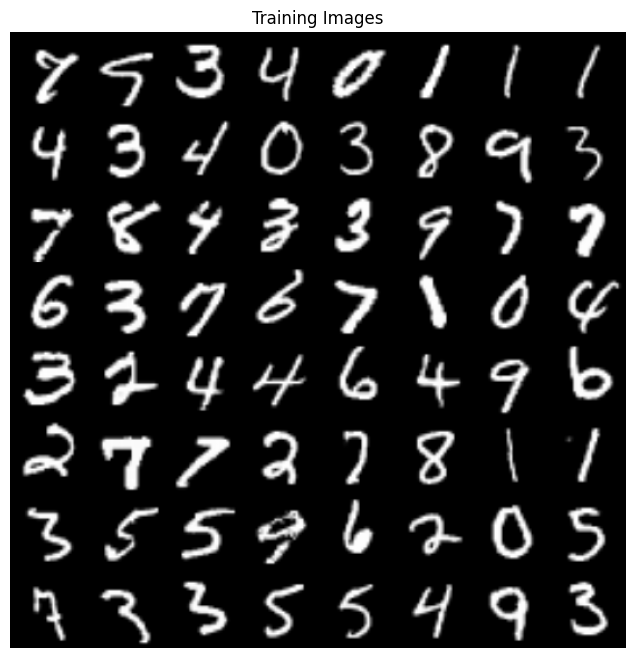

In [14]:
import torchvision.utils as vutils

# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(NOISE_SIZE, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [16]:
x = torch.randn(1, NOISE_SIZE, 1, 1)
print("Input", x.shape)
disc = Generator()
with torch.no_grad():
    for m in disc.main.children():
        x = m(x)
        if type(m).__name__.startswith('Conv'):
            print(f"[{m}]")
            print(x.shape)

Input torch.Size([1, 100, 1, 1])
[ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)]
torch.Size([1, 512, 4, 4])
[ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)]
torch.Size([1, 256, 8, 8])
[ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)]
torch.Size([1, 128, 16, 16])
[ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)]
torch.Size([1, 64, 32, 32])
[ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)]
torch.Size([1, 1, 64, 64])


In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNELS, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [18]:
x = torch.randn(1, 1, 64, 64)
print("Input", x.shape)
disc = Discriminator()
with torch.no_grad():
    for m in disc.main.children():
        x = m(x)
        if type(m).__name__.startswith('Conv'):
            print(f"[{m}]")
            print(x.shape)

Input torch.Size([1, 1, 64, 64])
[Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)]
torch.Size([1, 64, 32, 32])
[Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)]
torch.Size([1, 128, 16, 16])
[Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)]
torch.Size([1, 256, 8, 8])
[Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)]
torch.Size([1, 512, 4, 4])
[Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)]
torch.Size([1, 1, 1, 1])


In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Create the generator
model_G = Generator().to(device)
model_G.apply(weights_init)

# Create the discriminator
model_D = Discriminator().to(device)
model_D.apply(weights_init)
pass

Since this is a classification problem for two classes with a single output we will use BCELoss

In [20]:
out = torch.tensor([np.log(4.0), np.log(2.0)])
expected = torch.tensor([1.0, 0.0])
print(nn.CrossEntropyLoss()(out, expected))

tensor(0.4055, dtype=torch.float64)


In [21]:
out = torch.tensor([4/6])
expected = torch.tensor([1.0])
print(nn.BCELoss()(out, expected))

tensor(0.4055)


In [22]:
# Initialize BCELoss function
loss_fn = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(model_D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = optim.Adam(model_G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [23]:
import subprocess
def get_gpu_temperature():
    try:
        result = subprocess.run(["nvidia-smi", "--query-gpu=temperature.gpu", "--format=csv,noheader,nounits"],
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        if result.returncode == 0:
            temperature = int(result.stdout.strip())
            return temperature
        else:
            print("Error running nvidia-smi:")
            print(result.stderr)
            return None
    except Exception as e:
        print("An error occurred:", str(e))
        return None
    
get_gpu_temperature()

55

In [24]:
import time

# Lists to keep track of progress
G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(EPOCHS):
    for i, data in enumerate(dataloader, 0):

        if get_gpu_temperature() >= 79:
            print("GPU too hot. Waiting...")
            time.sleep(30)
            print("- resuming ...")

        # Update the discriminator
        model_D.zero_grad()

        ### with real data
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), REAL_LABEL, dtype=torch.float, device=device)
        output = model_D(real_images).view(-1)
        loss_real = loss_fn(output, label)
        loss_real.backward()
        conf_D_real = output.mean().item()

        ### with fake data
        noise = torch.randn(batch_size, NOISE_SIZE, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(FAKE_LABEL)
        output = model_D(fake.detach()).view(-1)
        loss_fake = loss_fn(output, label)
        loss_fake.backward()
        conf_D_fake = 1 - output.mean().item()
        loss_D = loss_real + loss_fake
        optimizerD.step()

        # Update the generator
        model_G.zero_grad()
        label.fill_(REAL_LABEL)  
        output = model_D(fake).view(-1)
        loss_G = loss_fn(output, label)
        loss_G.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                  % (epoch, EPOCHS, i, len(dataloader),
                     loss_D.item(), loss_G.item(), conf_D_real, conf_D_fake))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

Starting Training Loop...
[0/5][0/469]	Loss_D: 2.0826	Loss_G: 1.6011	D(x): 0.2350	D(G(z)): 0.7046
[0/5][50/469]	Loss_D: 0.3034	Loss_G: 17.6109	D(x): 0.9576	D(G(z)): 0.7997
[0/5][100/469]	Loss_D: 0.1604	Loss_G: 4.2875	D(x): 0.9155	D(G(z)): 0.9618
[0/5][150/469]	Loss_D: 0.0712	Loss_G: 5.1629	D(x): 0.9484	D(G(z)): 0.9860
[0/5][200/469]	Loss_D: 0.1965	Loss_G: 4.7700	D(x): 0.9603	D(G(z)): 0.8707
[0/5][250/469]	Loss_D: 2.3322	Loss_G: 7.5533	D(x): 0.9566	D(G(z)): 0.2224
[0/5][300/469]	Loss_D: 0.2060	Loss_G: 3.2805	D(x): 0.8986	D(G(z)): 0.9248
[0/5][350/469]	Loss_D: 0.2458	Loss_G: 3.2174	D(x): 0.9277	D(G(z)): 0.8541
[0/5][400/469]	Loss_D: 0.3604	Loss_G: 2.6443	D(x): 0.8389	D(G(z)): 0.8542
[0/5][450/469]	Loss_D: 2.3167	Loss_G: 0.4265	D(x): 0.1590	D(G(z)): 0.9978
[1/5][0/469]	Loss_D: 0.3012	Loss_G: 2.2056	D(x): 0.7948	D(G(z)): 0.9476
[1/5][50/469]	Loss_D: 0.3939	Loss_G: 1.7578	D(x): 0.7778	D(G(z)): 0.8888
[1/5][100/469]	Loss_D: 0.3291	Loss_G: 3.8363	D(x): 0.9607	D(G(z)): 0.7659
[1/5][150/469]	Lo

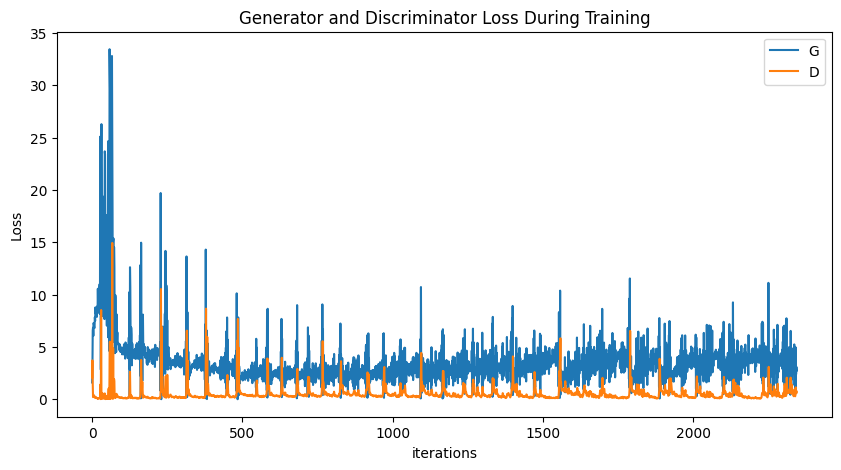

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.Size([1, 1, 64, 64])


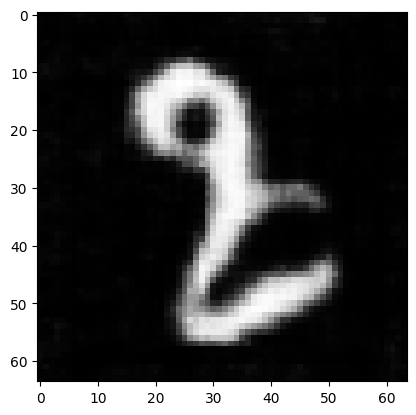

In [26]:
with torch.no_grad():
    x = torch.randn(1, 100, 1, 1, device=device)
    image = model_G(x)
    print(image.shape)
    plt.imshow(image[0].squeeze().cpu(), cmap='gray')

In [27]:
torch.save(model_G.state_dict(), 'models/netG.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'models/netG.pth'

In [ ]:
model2 = Generator()
model2.load_state_dict(torch.load('models/netG.pth'))
model2 = model2.to(device)
model2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    x = torch.randn(1, 100, 1, 1, device=device)
    image = model2(x)
    print(image.shape)
    plt.imshow(image[0].squeeze().cpu(), cmap='gray')